In [10]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ==== Dataset ====

class BacteriaBoxDataset(Dataset):
    def __init__(self, image_path, box_file_path, powierzchnie_mm, selected_indices=None, img_size=64):
        self.image = cv2.imread(image_path)
        self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        self.h, self.w, _ = self.image.shape
        self.img_size = img_size
        self.samples = []

        with open(box_file_path, 'r') as f:
            lines = f.readlines()

        if selected_indices is not None:
            lines = [lines[i] for i in selected_indices]

        assert len(lines) == len(powierzchnie_mm), "Mismatch between filtered boxes and powierzchnie_mm"

        for i, line in enumerate(lines):
            _, x, y, bw, bh = map(float, line.strip().split())
            x1 = int((x - bw / 2) * self.w)
            y1 = int((y - bh / 2) * self.h)
            x2 = int((x + bw / 2) * self.w)
            y2 = int((y + bh / 2) * self.h)

            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(self.w - 1, x2), min(self.h - 1, y2)

            crop = self.image[y1:y2, x1:x2]
            if crop.size == 0: continue
            crop = cv2.resize(crop, (img_size, img_size))
            crop = crop / 255.0
            self.samples.append((crop.astype(np.float32), float(powierzchnie_mm[i])))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img, target = self.samples[idx]
        img = torch.tensor(img).permute(2, 0, 1)  # CxHxW
        target = torch.tensor([target], dtype=torch.float32)
        return img, target

# ==== CNN Model ====

class SurfaceAreaCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

In [11]:
def train_model(image_path, box_file_path, powierzchnie_mm, batch_size=16, epochs=20, lr=1e-3):
    all_indices = list(range(len(powierzchnie_mm)))

    # Split indices, not values
    train_idx, val_idx = train_test_split(all_indices, test_size=0.2, random_state=42)

    # Use index lists to create subset data for both boxes and powierzchniamm
    train_pow = [powierzchnie_mm[i] for i in train_idx]
    val_pow = [powierzchnie_mm[i] for i in val_idx]

    train_dataset = BacteriaBoxDataset(image_path, box_file_path, train_pow, selected_indices=train_idx)
    val_dataset = BacteriaBoxDataset(image_path, box_file_path, val_pow, selected_indices=val_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = SurfaceAreaCNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X, y in train_loader:
            pred = model(X)
            loss = loss_fn(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, y in val_loader:
                pred = model(X)
                loss = loss_fn(pred, y)
                val_loss += loss.item() * X.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    # Plot loss
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Val")
    plt.title("Loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()

    return model

Epoch 1/30: Train Loss = 2.2481, Val Loss = 6.5446
Epoch 2/30: Train Loss = 1.9682, Val Loss = 5.7452
Epoch 3/30: Train Loss = 1.5128, Val Loss = 7.6479
Epoch 4/30: Train Loss = 1.6386, Val Loss = 7.7736
Epoch 5/30: Train Loss = 1.6411, Val Loss = 7.2166
Epoch 6/30: Train Loss = 1.4688, Val Loss = 6.4286
Epoch 7/30: Train Loss = 1.3791, Val Loss = 6.0786
Epoch 8/30: Train Loss = 1.4476, Val Loss = 5.9281
Epoch 9/30: Train Loss = 1.4468, Val Loss = 6.5090
Epoch 10/30: Train Loss = 1.3547, Val Loss = 6.5186
Epoch 11/30: Train Loss = 1.3473, Val Loss = 6.6389
Epoch 12/30: Train Loss = 1.3037, Val Loss = 6.3150
Epoch 13/30: Train Loss = 1.2106, Val Loss = 6.5301
Epoch 14/30: Train Loss = 1.2203, Val Loss = 6.4736
Epoch 15/30: Train Loss = 0.9439, Val Loss = 7.4384
Epoch 16/30: Train Loss = 0.7211, Val Loss = 7.5672
Epoch 17/30: Train Loss = 0.4421, Val Loss = 8.7085
Epoch 18/30: Train Loss = 0.5726, Val Loss = 11.3060
Epoch 19/30: Train Loss = 0.4835, Val Loss = 10.8630
Epoch 20/30: Train 

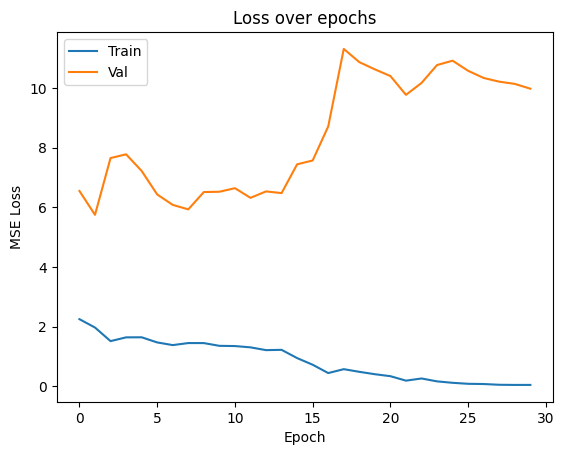

In [16]:
import pandas as pd

df = pd.read_csv("raport_5_x_2.csv")

# Replace this with real values
powierzchnie_mm = list(df['powierzchniamm'])

model = train_model(
    image_path='a1.jpg',
    box_file_path='a1.txt',
    powierzchnie_mm=powierzchnie_mm,
    batch_size=8,
    epochs=30,
    lr=1e-3
)
